# Homework 2 Solutions

In [4]:
import numpy as np
import sympy as sp
import jax
import jax.numpy as jnp
from jax import config

from scipy import sparse
from scipy.sparse import linalg

config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

import niceplots

plt.style.use(niceplots.get_style())
colors = niceplots.get_colors_list()

## Problem 1: Finite difference stencil

### Using the method of undetermined coefficients

In [5]:
# Define symbolic variables
a0, a1, a2, a3, a4, h = sp.symbols('a0, a1, a2, a3, a4, h')

# Define the matrix A and vector b symbolically
A = sp.Matrix([
    [1, 1, 1, 1, 1],
    [0, 1, 2, 3, 4],
    [0, 1/2, 2, 9/2, 8],
    [0, 1/6, 4/3, 9/2, 32/3],
    [0, 1/24, 2/3, 27/8, 32/3]
])

b = sp.Matrix([0, 1/h, 0, 0, 0])

# Solve for x symbolically
solution = A.solve(b)

# Print the symbolic solution
sp.pprint(solution)


⎡-2.08333333333333 ⎤
⎢──────────────────⎥
⎢        h         ⎥
⎢                  ⎥
⎢       4.0        ⎥
⎢       ───        ⎥
⎢        h         ⎥
⎢                  ⎥
⎢      -3.0        ⎥
⎢      ─────       ⎥
⎢        h         ⎥
⎢                  ⎥
⎢ 1.33333333333333 ⎥
⎢ ──────────────── ⎥
⎢        h         ⎥
⎢                  ⎥
⎢      -0.25       ⎥
⎢      ──────      ⎥
⎣        h         ⎦


### Using Lagrange polynomials

In [6]:
def get_lagrange_func(xPoints, i):
    """Create a function that computes the ith Lagrange polynomial for a given set of points.

    Parameters
    ----------
    xPoints : list/array of floats
        X coordinate values of the points to be interpolated
    i : int
        The index of the lagrange polynomial to create (must be between 0 and len(x)-1)

    Returns
    -------
    function
        A function that computes the ith Lagrange polynomial for a given x value, e.g. L_i(x)
    """

    def lagrange_poly(x):
        result = 1.0
        N = len(xPoints)
        for j in range(N):
            if j != i:
                result *= (x - xPoints[j]) / (xPoints[i] - xPoints[j])
        return result

    return lagrange_poly

xPoints = [0, h, 2*h, 3*h, 4*h]
x = sp.symbols('x')
for i in range(len(xPoints)):
    print(f"L_{i}(x) = {sp.simplify(get_lagrange_func(xPoints, i)(x))}")

print("\n\nCoefficients for first derivative:")
for i in range(len(xPoints)):
    dLdx = sp.diff(get_lagrange_func(xPoints, i)(x), x)
    print(f"a_{i} = dL_{i}/dx | x=0 = {dLdx.subs(x, 0)}")

print("\n\nCoefficients for 2nd derivative:")
for i in range(len(xPoints)):
    d2Ldx2 = sp.diff(get_lagrange_func(xPoints, i)(x), x, 2)
    print(f"a_{i} = d^2L_{i}/dx^2 | x=0 = {d2Ldx2.subs(x, 0)}")

L_0(x) = 0.0416666666666667*(h - x)*(2*h - x)*(3*h - x)*(4*h - x)/h**4
L_1(x) = 0.166666666666667*x*(2*h - x)*(3*h - x)*(4*h - x)/h**4
L_2(x) = -0.25*x*(h - x)*(3*h - x)*(4*h - x)/h**4
L_3(x) = 0.166666666666667*x*(h - x)*(2*h - x)*(4*h - x)/h**4
L_4(x) = -0.0416666666666667*x*(h - x)*(2*h - x)*(3*h - x)/h**4


Coefficients for first derivative:
a_0 = dL_0/dx | x=0 = -2.08333333333333/h
a_1 = dL_1/dx | x=0 = 4.0/h
a_2 = dL_2/dx | x=0 = -3.0/h
a_3 = dL_3/dx | x=0 = 1.33333333333333/h
a_4 = dL_4/dx | x=0 = -0.25/h


Coefficients for 2nd derivative:
a_0 = d^2L_0/dx^2 | x=0 = 2.91666666666667/h**2
a_1 = d^2L_1/dx^2 | x=0 = -8.66666666666667/h**2
a_2 = d^2L_2/dx^2 | x=0 = 9.5/h**2
a_3 = d^2L_3/dx^2 | x=0 = -4.66666666666667/h**2
a_4 = d^2L_4/dx^2 | x=0 = 0.916666666666667/h**2


## Problem 2: Lagrange interpolation with Jax

In [7]:
import jax
import jax.numpy as jnp

x_data = jnp.array([0.0, 1.0, 2.0, 3.0, 4.0])

print("Coefficients for first derivative:")
for i in range(len(x_data)):
    L = get_lagrange_func(x_data, i)
    dLdx = jax.grad(L)
    coeff = dLdx(0.0)
    print(f"a_{i} = dL_{i}/dx | x=0 = {coeff}")

print("\n\nCoefficients for second derivative:")
for i in range(len(x_data)):
    L = get_lagrange_func(x_data, i)
    d2Ldx2 = jax.grad(jax.grad(L))
    coeff = d2Ldx2(0.0)
    print(f"a_{i} = d^2L_{i}/dx^2 | x=0 = {coeff}")


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Coefficients for first derivative:
a_0 = dL_0/dx | x=0 = -2.083333333333333
a_1 = dL_1/dx | x=0 = 4.0
a_2 = dL_2/dx | x=0 = -3.0
a_3 = dL_3/dx | x=0 = 1.3333333333333333
a_4 = dL_4/dx | x=0 = -0.25


Coefficients for second derivative:
a_0 = d^2L_0/dx^2 | x=0 = 2.9166666666666665
a_1 = d^2L_1/dx^2 | x=0 = -8.666666666666666
a_2 = d^2L_2/dx^2 | x=0 = 9.5
a_3 = d^2L_3/dx^2 | x=0 = -4.666666666666667
a_4 = d^2L_4/dx^2 | x=0 = 0.9166666666666666


## Problem 3: 2D finite difference method

### Part a)

In [8]:
def solve(N):
  L = 1
  h = 1./N
  h2 = h*h
  x = np.linspace(0, L, N+1) # x nodes
  y = np.linspace(0, L, N+1) # y nodes
  Y, X = np.meshgrid(y, x) # matrices of all nodes
  Nu = (N+1)*(N+1) # total number of unknowns
  nnz = (4+2*(N-1)+2*(N-1))*1 + (N-1)*(N-1)*5 # number of nonzeros
  data = np.zeros(nnz, dtype=float)
  irow = np.zeros(nnz, dtype=int)
  icol = np.zeros(nnz, dtype=int)
  q = np.zeros(Nu) # empty rhs vector

  # fill in interior contributions
  inz=0
  for iy in range(1,N):
    for ix in range(1,N):
      i = iy*(N+1)+ix
      q[i] = 0
      iLD = i-(N+1)-1
      iRD = iLD+2
      iLU = i+(N+1)-1
      iRU = iLU+2
      I = range(inz+0,inz+5)
      irow[I] = i
      icol[I] = [i, iLD, iRU, iLU, iRD]
      data[I] = [-(1+X[ix,iy]*Y[ix,iy]), 0.25/h2, 0.25/h2, -0.25/h2, -0.25/h2]
      inz += 5

  # enforce Dirichlet boundary conditions
  for ix in range(N+1):
    irow[inz] = icol[inz] = ix
    data[inz] = 1.
    q[irow[inz]] = np.exp(X[ix,0]*Y[ix,0])
    inz+=1
    irow[inz] = icol[inz] = N*(N+1)+ix
    data[inz] = 1.
    q[irow[inz]] = np.exp(X[ix,N]*Y[ix,N])
    inz+=1
  for iy in range(1,N):
    irow[inz] = icol[inz] = iy*(N+1)
    data[inz] = 1.
    q[irow[inz]] = np.exp(X[0,iy]*Y[0,iy])
    inz+=1
    irow[inz] = icol[inz] = iy*(N+1)+N
    data[inz] = 1.
    q[irow[inz]] = np.exp(X[N,iy]*Y[N,iy])
    inz+=1

  print('nnz=%d, inz=%d\n'%(nnz,inz))

  # build sparse matrix
  A = sparse.csr_matrix((data, (irow, icol )), shape=(Nu,Nu))

  # solve system
  Uv = linalg.spsolve(A,q) # solution at all points
  U = np.reshape(Uv, (N+1,N+1), order='F') # reshape into matrix

  return X, Y, U, A

nnz=61, inz=61

nnz=1189, inz=1189



(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='x', ylabel='y'>)

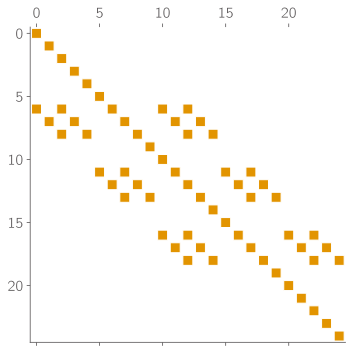

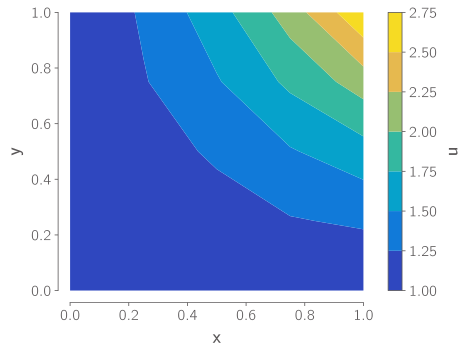

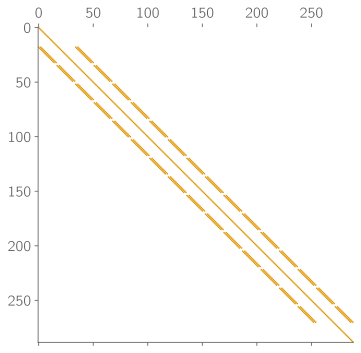

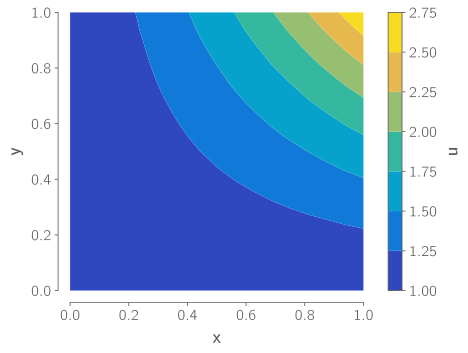

In [17]:
def plotSolution(X, Y, U):
    fig, ax = plt.subplots()
    contour = ax.contourf(X, Y, U, cmap=niceplots.parula_map)
    fig.colorbar(contour, label='u')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    niceplots.adjust_spines(ax)
    return fig, ax

X, Y, U, A = solve(4)
fig, ax = plt.subplots()
ax.spy(A)
plotSolution(X, Y, U)

X, Y, U, A = solve(16)
fig, ax = plt.subplots()
ax.spy(A, markersize=0.5, markeredgecolor="auto")
plotSolution(X, Y, U)

### Part b)

In [10]:
# convergence study
def convergenceStudy(vN):
    E = np.zeros(len(vN))
    for i, N in enumerate(vN):
        X, Y, U = solve(N)
        E[i] = np.sqrt(np.sum((np.exp(X*Y)-U)**2)/(N+1)**2)
    print(E)

    fig, ax = plt.subplots()
    m = np.log2(E[-2]/E[-1])

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(vN, E,'-o', label=f'rate = {m: .3f}', clip_on=False)

    ax.legend()
    ax.set_xlabel(r'$N$ = number of intervals')
    ax.set_ylabel(r'$L 2$ error')
    niceplots.adjust_spines(ax)
    return m

vN = [4,8,16,32]
convergenceStudy(vN)
plt.savefig("HW2-Convergence.pdf")

nnz=61, inz=61



ValueError: too many values to unpack (expected 3)

From this result, it seems we have not quite reached the asymptotic region of convergence where the rate of convergence = 2. We can get there by increasing the number of grid points in each direction further.

nnz=61, inz=61

nnz=277, inz=277

nnz=1189, inz=1189

nnz=4933, inz=4933

nnz=20101, inz=20101

nnz=81157, inz=81157

nnz=326149, inz=326149

[1.49059875e-02 5.06700792e-03 1.46965488e-03 3.95347795e-04
 1.02503087e-04 2.60954129e-05 6.58328493e-06]


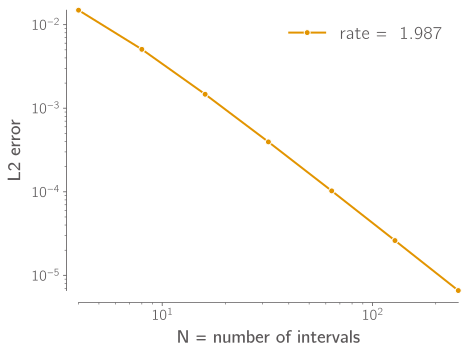

In [ ]:

vN = [4,8,16,32, 64, 128, 256]
convergenceStudy(vN)
plt.savefig("HW2-ConvergenceContinued.pdf")